In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [512, 512]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 1

print(ROOT_PATH)

/aiffel/aiffel


In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [5]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-0871-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1345_bacteria_3422.jpeg


In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1078
Pneumonia images count in training set: 3107


In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [8]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [9]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [10]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (512, 512, 3)
Label:  False


In [13]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [14]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

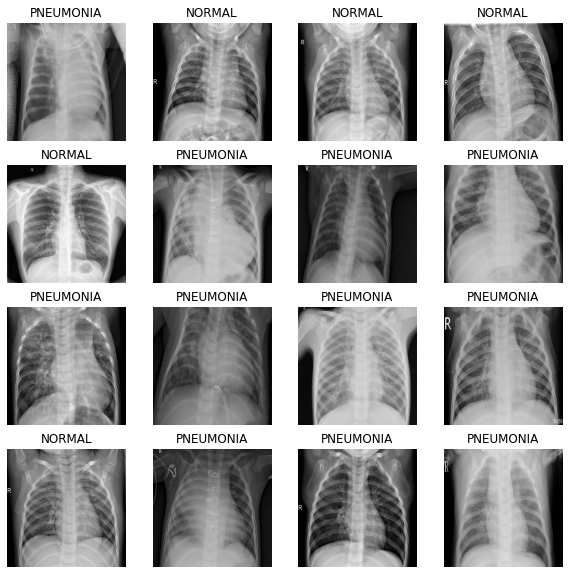

In [15]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## UNET

- Architecture<br>
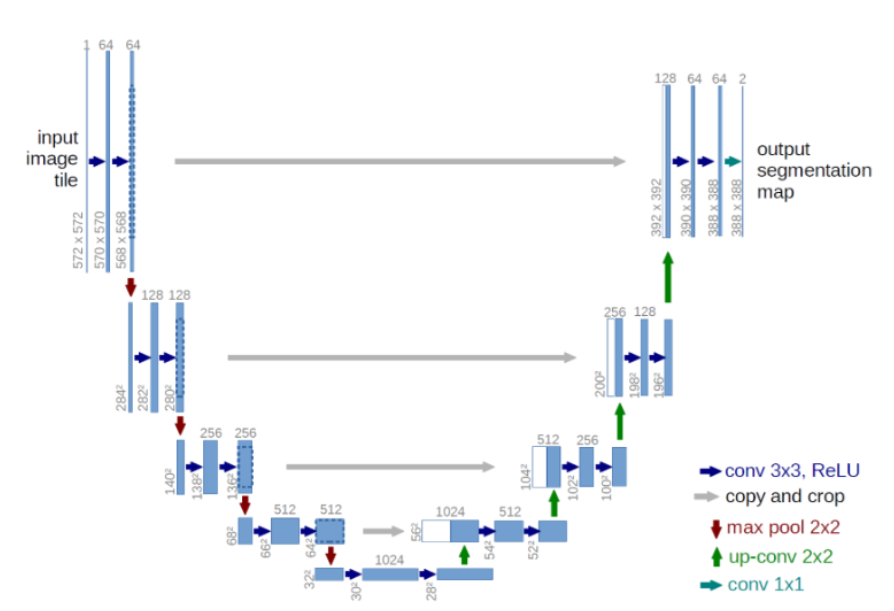


- 왼쪽 contracting path 
    - 이미지의 특성 압축
    - padding 과정 없이 컨볼루전
- 오른쪽 extracting path
    - 이미지 복원, 업샘플링 진행
    - 각 contracting path의 컨볼루전 결과를 crop, copy하여 업샘플링한 레이어와 concat

In [16]:
import numpy as np
from tensorflow.keras.layers import  Flatten, Conv2D, MaxPooling2D, Dense, Dropout, Softmax, Conv2DTranspose, BatchNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.applications.vgg16 import VGG16
import tensorflow as tf

In [17]:
def contract_path(input_shape):
    input = tf.keras.layers.Input(shape = input_shape)
    x = Conv2D(64, (3,3), activation='relu')(input)
    x = Conv2D(64, (3,3), activation='relu', name='copy_crop1')(x)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(128, (3,3), activation='relu')(x)
    x = Conv2D(128, (3,3), activation='relu', name='copy_crop2')(x)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(256, (3,3), activation='relu')(x)
    x = Conv2D(256, (3,3), activation='relu', name='copy_crop3')(x)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(512, (3,3), activation='relu')(x)
    x = Conv2D(512, (3,3), activation='relu', name='copy_crop4')(x)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(1024, (3,3), activation='relu')(x)
    x = Conv2D(512, (3,3), activation='relu', name='last_layer')(x)
    contract_path = tf.keras.Model(inputs = input, outputs=x)
    return contract_path

In [18]:
def croppped_layer(input, crop_input):
    crop = crop_input
    x_shape = input.shape
    crop_shape = crop.shape
    offsets = [0, (crop_shape[1] - x_shape[1]) // 2, (crop_shape[2] - x_shape[2]) // 2, 0]
    size = [-1, x_shape[1], x_shape[2], -1]
    cropped = tf.slice(crop, offsets,size)
    x = tf.keras.layers.Concatenate()([cropped, input])
    return x

In [19]:
def unet(input_shape, n_classes):
    contract_model = contract_path(input_shape=input_shape)
    layer_names = ["copy_crop1", "copy_crop2",  "copy_crop3" ,"copy_crop4", "last_layer"]
    layers = [contract_model.get_layer(name).output for name in layer_names]
    
    extract_model = tf.keras.Model(inputs=contract_model.input, outputs=layers)
    input_ = tf.keras.layers.Input(shape=input_shape)  # Change variable name to input_
    output_layers = extract_model(inputs=input_)
    last_layer = output_layers[-1]
    
    x = Conv2DTranspose(512, 4 , (2,2), padding='same', activation='relu')(last_layer)
    x = BatchNormalization()(x)
    x = croppped_layer(x, output_layers[3])
    
    x = Conv2D(256, (3,3), activation='relu')(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(256, (3,3), activation='relu')(x)
    x = BatchNormalization()(x)
    
    x = Conv2DTranspose(256, 4 , (2,2), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = croppped_layer(x, output_layers[2])
    
    x = Conv2D(128, (3,3), activation='relu')(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(128, (3,3), activation='relu')(x)
    x = BatchNormalization()(x)
    
    x = Conv2DTranspose(128, 4 , (2,2), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = croppped_layer(x, output_layers[1])
    
    x = Conv2D(64, (3,3), activation='relu')(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(64, (3,3), activation='relu')(x)
    x = BatchNormalization()(x)
    
    x = Conv2DTranspose(64, 4 , (2,2), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = croppped_layer(x, output_layers[0])
    
    x = Conv2D(64, (3,3), activation='relu')(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(64, (3,3), activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(n_classes, (1,1),activation='sigmoid')(x)
    x = Flatten()(x)
    x = Dense(n_classes, activation='softmax')(x)
   
    return tf.keras.Model(inputs=input_, outputs=x)

In [20]:
unet_model = unet(input_shape=(512, 512, 3), n_classes=1)

In [21]:
unet_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
model_1 (Functional)            [(None, 508, 508, 64 14124096    input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_transpose (Conv2DTranspo (None, 48, 48, 512)  4194816     model_1[0][4]                    
__________________________________________________________________________________________________
tf.slice (TFOpLambda)           (None, 48, 48, 512)  0           model_1[0][3]                    
____________________________________________________________________________________________

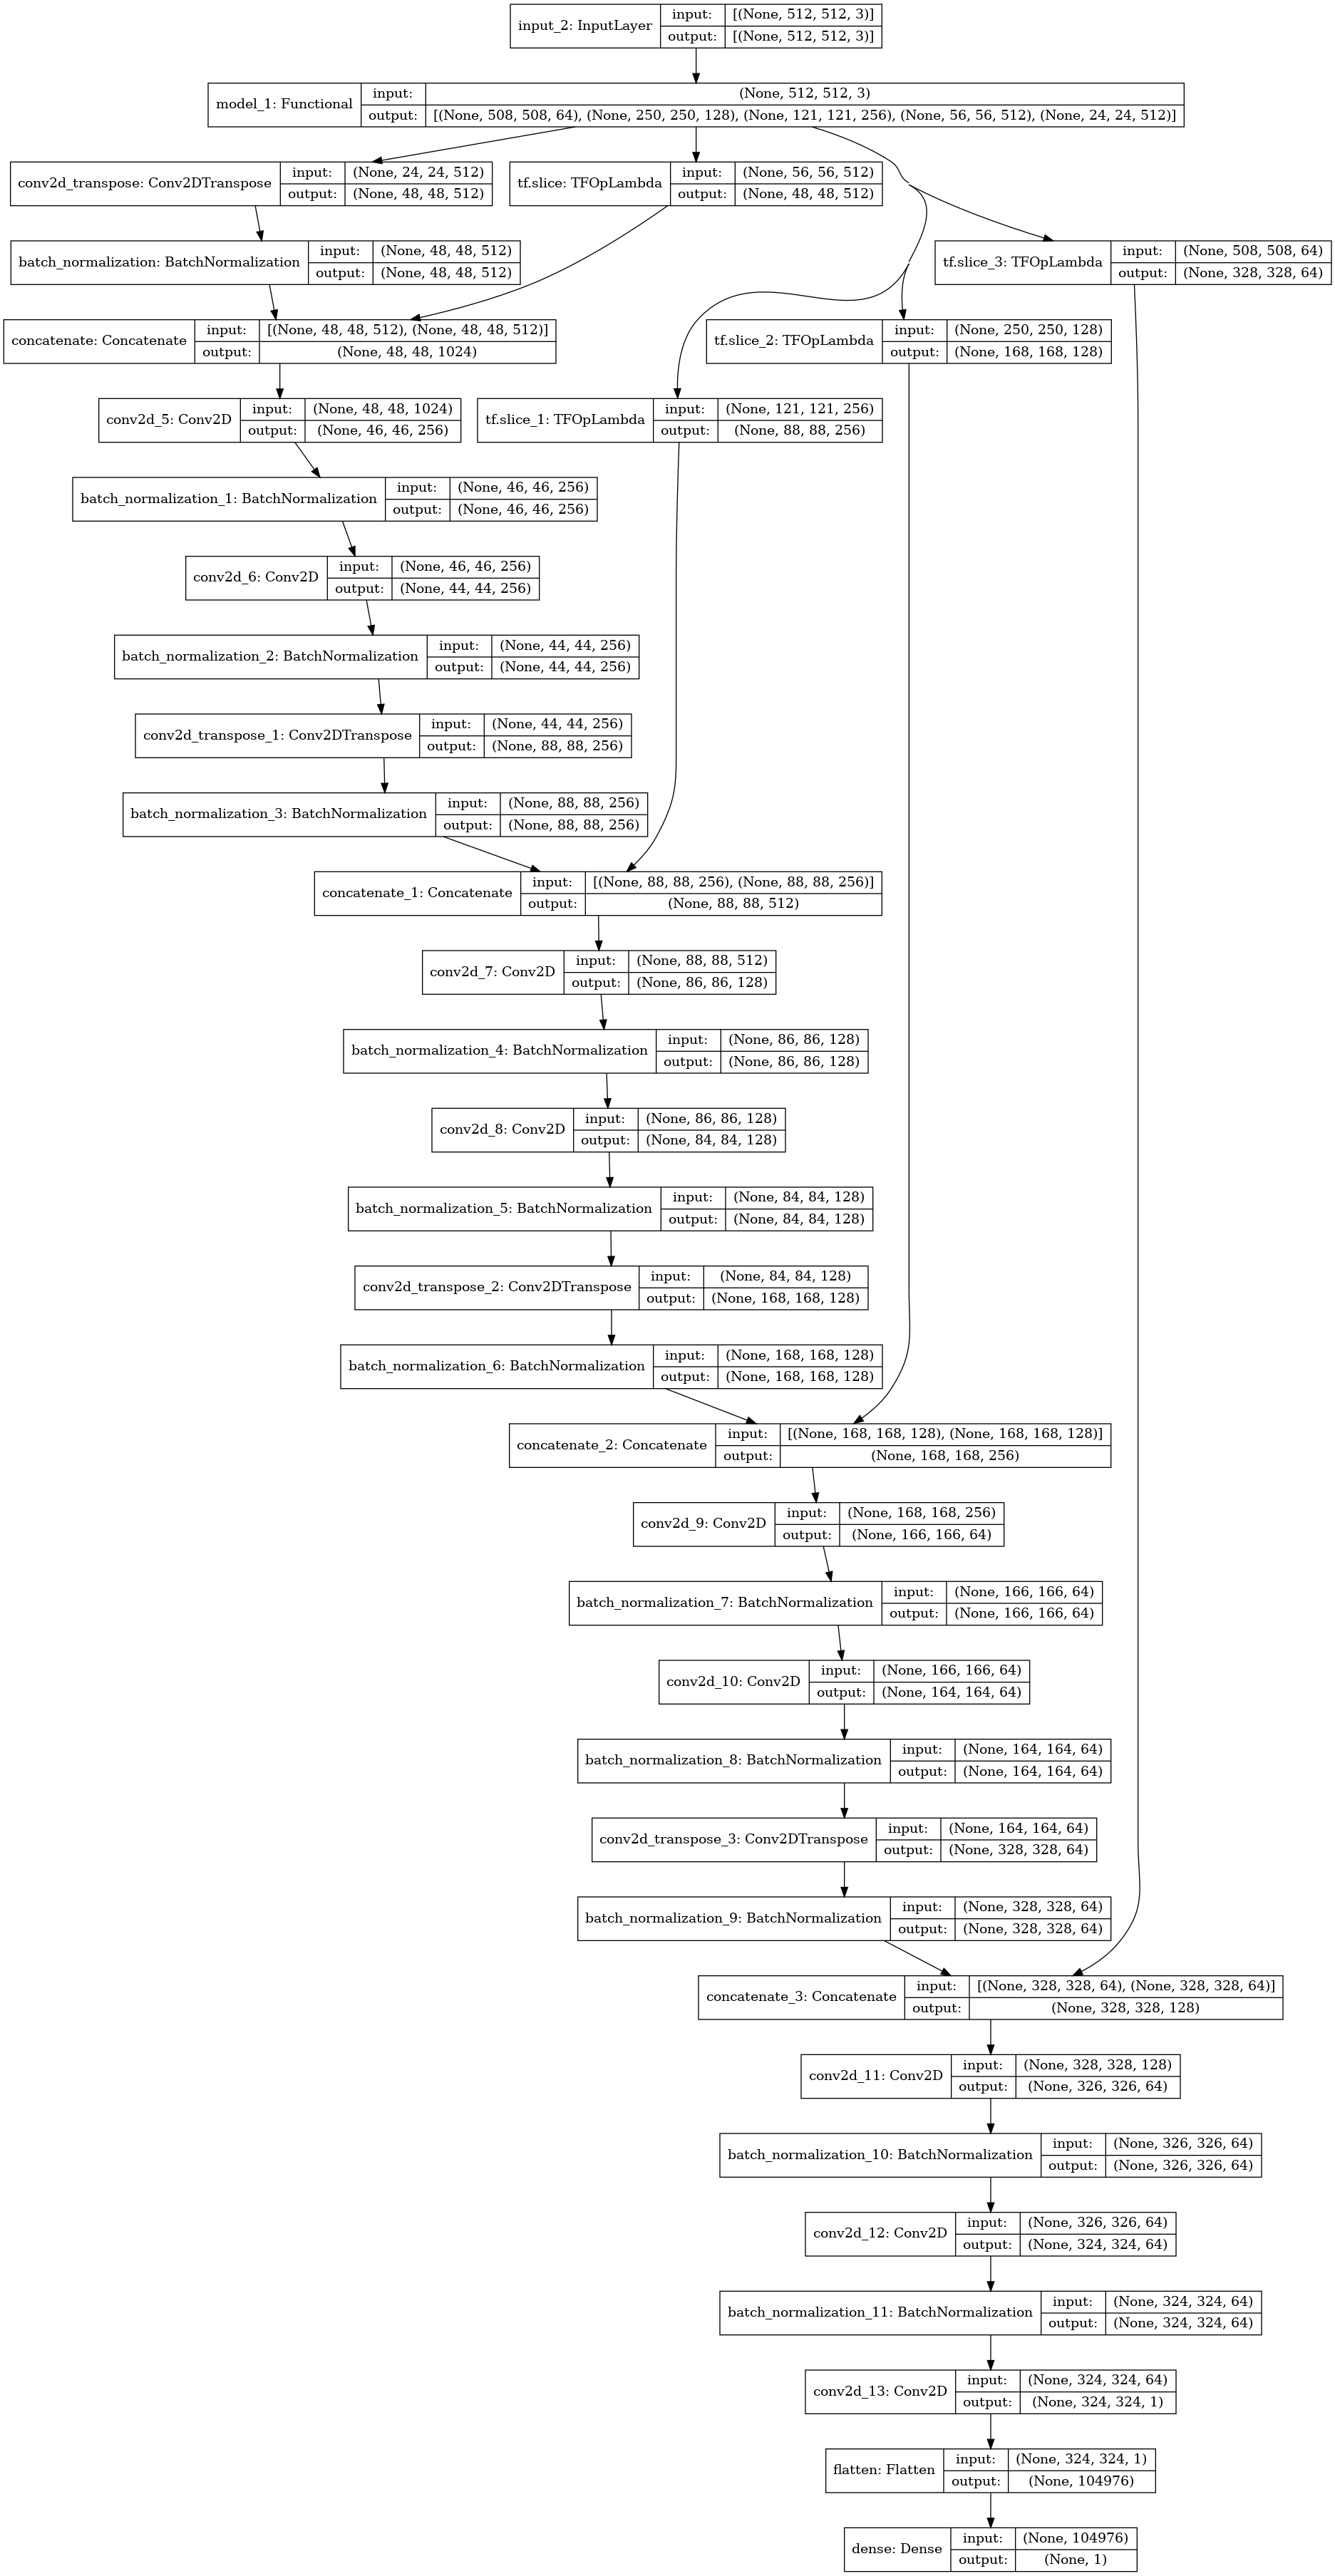

In [22]:
import matplotlib.pyplot as plt
import warnings 
from tensorflow.keras.utils import plot_model

warnings.filterwarnings(action='ignore')

# Assuming 'model' is your unet model
plot_model(unet_model, show_shapes=True, to_file='unet_model.png')

In [23]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.94
Weight for PNEUMONIA: 0.67


In [24]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

num_classes = 1
input_shape = (512, 512, 3)

with tf.device('/GPU:0'):
    model = unet(input_shape=input_shape, n_classes=num_classes)  # Use the unet function
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )


In [25]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE
    )

261/261 [==============================] - 614s 2s/step - loss: 0.6510 - accuracy: 0.7423 - precision: 0.7423 - recall: 1.0000 - val_loss: 3.2099 - val_accuracy: 0.7404 - val_precision: 0.7404 - val_recall: 1.0000


In [27]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 23s 573ms/step - loss: 4.3936 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 4.393612384796143,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0
